In [22]:
import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import tqdm.auto as tqdm

In [23]:
#!/usr/bin/env python
"""
Compare EN ↔ FR LaBSE features with a configurable context window
and the same layer pooling you save in your extractor:
    pool_l3_5   = mean-pool layers 3-5
    pool_l6_8   = mean-pool layers 6-8
    pool_l8_10  = mean-pool layers 8-10
"""

MODEL_ID = "setu4993/LaBSE"
tok   = AutoTokenizer.from_pretrained(MODEL_ID)
enc   = AutoModel.from_pretrained(MODEL_ID, output_hidden_states=True).eval()

# -------------------------------------------------------------------------
def load_column(path):
    df = pd.read_csv(path, sep="\t", keep_default_na=False)
    return list(df["text_per_tr"])

def build_windows(lines, before, after):
    N = len(lines)
    windows = []
    is_empty = np.array([len(line.strip()) == 0 for line in lines])
    for idx in range(N):
        s = max(0, idx - before)
        e = min(N, idx + after + 1)     # exclusive
        windows.append(" ".join(lines[s:e]))

    return windows, is_empty

# masked mean pooling helper
def masked_mean(hidden, attn_mask):
    return (hidden * attn_mask.unsqueeze(-1)).sum(dim=1) / attn_mask.sum(dim=1, keepdim=True)

def extract_three_features(texts, batch=32):
    f1, f2, f3 = [], [], []   # pool_l3_5, pool_l6_8, pool_l8_10
    for i in range(0, len(texts), batch):
        batch_txt = texts[i:i+batch]
        inputs = tok(batch_txt, padding=True, truncation=True, max_length=512, return_tensors="pt")
        with torch.no_grad():
            outs = enc(**inputs, output_hidden_states=True)
        attn = inputs["attention_mask"]
        hs = outs.hidden_states   # list length 13

        def pool_layers(start, end):
            layers = hs[start:end]          # slice end exclusive
            return torch.stack([masked_mean(h, attn) for h in layers]).mean(0)

        f1.append(pool_layers(3, 6).cpu())   # 3-5
        f2.append(pool_layers(6, 9).cpu())   # 6-8
        f3.append(pool_layers(8,11).cpu())   # 8-10

    return {
        "pool_l3_5":  torch.cat(f1).numpy(),
        "pool_l6_8":  torch.cat(f2).numpy(),
        "pool_l8_10": torch.cat(f3).numpy(),
    }

def cosine_per_tr(matA, matB):
    return np.diag(cosine_similarity(matA, matB))

Extracting features:   0%|          | 0/15 [00:00<?, ?it/s]

pool_l3_5  (window −0,+0), mean=0.704, std=0.102
pool_l6_8  (window −0,+0), mean=0.796, std=0.106
pool_l8_10  (window −0,+0), mean=0.843, std=0.099
pool_l3_5  (window −1,+0), mean=0.735, std=0.091
pool_l6_8  (window −1,+0), mean=0.840, std=0.090
pool_l8_10  (window −1,+0), mean=0.881, std=0.077
pool_l3_5  (window −2,+0), mean=0.751, std=0.095
pool_l6_8  (window −2,+0), mean=0.854, std=0.094
pool_l8_10  (window −2,+0), mean=0.893, std=0.078
pool_l3_5  (window −1,+1), mean=0.767, std=0.065
pool_l6_8  (window −1,+1), mean=0.871, std=0.055
pool_l8_10  (window −1,+1), mean=0.907, std=0.047
pool_l3_5  (window −2,+1), mean=0.783, std=0.067
pool_l6_8  (window −2,+1), mean=0.884, std=0.057
pool_l8_10  (window −2,+1), mean=0.916, std=0.047


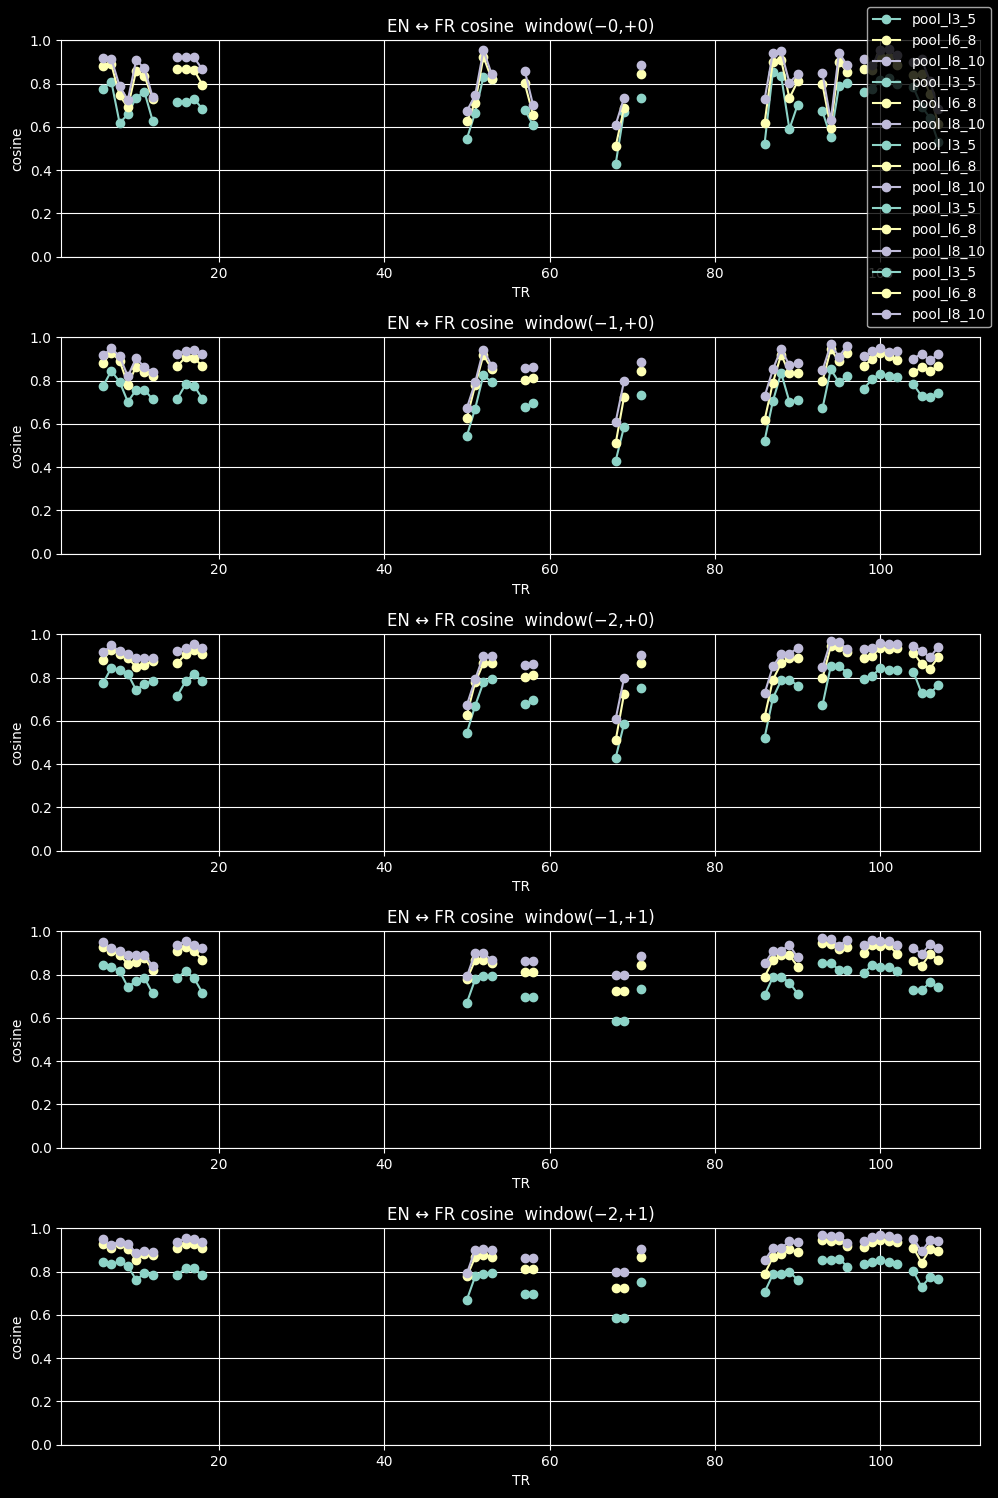

In [24]:
# -------------------------------------------------------------------------
en_lines = load_column("mock_en.tsv")
fr_lines = load_column("mock_fr.tsv")

windows = [
    (0, 0),
    (1, 0),
    (2, 0),
    (1, 1),
    (2, 1),
]

fig, axes = plt.subplots(len(windows), tight_layout=True, figsize=(10, 3 * len(windows)))

pbar = tqdm.tqdm(total=len(windows)*3, desc="Extracting features")
for i_plot, (before, after) in enumerate(windows):
    en_ctx, en_mask = build_windows(en_lines, before, after)
    fr_ctx, fr_mask = build_windows(fr_lines, before, after)

    emb_en = extract_three_features(en_ctx)
    emb_fr = extract_three_features(fr_ctx)

    for feat_name in emb_en:
        sim = cosine_per_tr(emb_en[feat_name], emb_fr[feat_name])
        sim = np.ma.masked_array(sim, en_mask * fr_mask)  # mask where there are no tokens
        print(f"{feat_name}  (window −{before},+{after}), mean={np.mean(sim):.3f}, std={np.std(sim):.3f}")
        axes[i_plot].plot(sim, marker="o", label=feat_name)
        pbar.update(1)

    axes[i_plot].set_title(f"EN ↔ FR cosine  window(−{before},+{after})")
    axes[i_plot].set_xlabel("TR")
    axes[i_plot].set_ylabel("cosine")
    axes[i_plot].set_ylim(0,1)
    axes[i_plot].grid(True)
fig.legend()
fig.show()
pbar.close()